In [1]:
# The code was removed by Watson Studio for sharing.

# Train a simple Employee promotion prediction model

## Use Case
This notebook demonstrates the implementation of a Random Forest Classification model for predicting employee promotions. The focus is on leveraging training the model with employee historical data for accurate predictions. Employee promotion prediction involves identifying factors that contribute to promotion decisions based on various features.

## What you'll learn in this notebook
Random Forest Classification: Random Forest is an ensemble learning method that constructs a multitude of decision trees during training and outputs the mode of the classes (classification) or mean prediction (regression) of the individual trees for robust and accurate predictions. Understand and implement the Random Forest algorithm for predicting employee promotions. The notebook covers the process of extracting relevant features, training the Random Forest model, and evaluating its performance in predicting employee promotions.

In [2]:
import os, types
import pandas as pd
from botocore.client import Config
import ibm_boto3

import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report, f1_score, recall_score, precision_score, roc_auc_score, roc_curve, auc
import matplotlib.pyplot as plt

## Load and prepare the data

In [3]:
# Download data asset from project storage and store it in the local file system
wslib.download_file("epp_train.csv", "epp_train.csv")

{'file_name': 'epp_train.csv', 'summary': ['loaded data', 'saved to file']}

In [4]:
# Read data from the CSV file into a DataFrame
employee_data = pd.read_csv("epp_train.csv")

# Change the order of the columns
employee_data = employee_data[['employee_id', 'department', 'region', 'education', 'gender',
       'recruitment_channel', 'no_of_trainings', 'age', 'previous_year_rating',
       'length_of_service', 'kpis_met_above_80_percent', 'any_awards_won',
       'avg_training_score', 'is_promoted']]

employee_data.head()

,employee_id,department,region,education,gender,recruitment_channel,no_of_trainings,age,previous_year_rating,length_of_service,kpis_met_above_80_percent,any_awards_won,avg_training_score,is_promoted
0,45709,Sales & Marketing,region_31,Bachelor's,f,other,1,29,NaN,1,0,0,49,0
1,66874,Sales & Marketing,region_27,Bachelor's,f,other,1,30,NaN,1,0,0,50,0
2,36904,Sales & Marketing,region_15,Bachelor's,m,other,1,29,3.0,2,0,0,51,0
3,32877,Sales & Marketing,region_2,Bachelor's,f,other,1,40,3.0,12,0,0,50,0
4,58415,Sales & Marketing,region_7,Bachelor's,m,other,1,45,4.0,5,0,0,50,0


In [5]:
employee_data.shape

(54808, 14)

In [6]:
employee_data.columns

Index(['employee_id', 'department', 'region', 'education', 'gender',
       'recruitment_channel', 'no_of_trainings', 'age', 'previous_year_rating',
       'length_of_service', 'kpis_met_above_80_percent', 'any_awards_won',
       'avg_training_score', 'is_promoted'],
      dtype='object')

In [7]:
employee_data = employee_data.drop(columns=["employee_id", "recruitment_channel", "region"])

## Balance the dataset with respect to *is_promoted*

Balancing the dataset with respect to the "is_promoted" variable is essential to avoid bias in the predictive model. When the dataset is imbalanced, with one class significantly outnumbering the other (e.g., promoted or not promoted employees), the model may exhibit a tendency to favor the majority class. In the context of employee promotion prediction, imbalance could lead to inaccurate predictions, especially if the majority of instances involve non-promotion.

In [8]:
# Separate the two classes
n = employee_data[employee_data['is_promoted'] == 1].count()[0]
class_0_data = employee_data[employee_data['is_promoted'] == 0]
class_1_data = employee_data[employee_data['is_promoted'] == 1]
print(employee_data['is_promoted'].value_counts())
# Take 3760 samples from class 0
class_0_sampled = class_0_data.sample(n, random_state=42)

# Combine the two classes to create a balanced dataset
employee_data = pd.concat([class_0_sampled, class_1_data])
print(employee_data['is_promoted'].value_counts())

0    50140
1     4668
Name: is_promoted, dtype: int64
0    4668
1    4668
Name: is_promoted, dtype: int64


In [9]:
employee_data.reset_index(drop=True,inplace=True)

## Data Preprocessing and Train-Test split
Data preprocessing, including handling missing values, encoding categorical columns, and splitting the dataset into training and test sets, with a check on the class distribution in the training data.

In [10]:
# Handle missing values
employee_data["education"].fillna(employee_data["education"].mode()[0], inplace=True)
employee_data["previous_year_rating"].fillna(1, inplace=True)

# Encode categorical columns
categorical_columns = employee_data.select_dtypes(include=['object']).columns.tolist()
X_encoded = pd.get_dummies(employee_data, columns=categorical_columns, drop_first=True)

# Split the data into features (X) and target (y)
y = X_encoded["is_promoted"]
X_encoded = X_encoded.drop("is_promoted", axis=1)

# Splitting the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X_encoded, y, test_size=0.2, random_state=42)

# Initializing a Random Forest Classifier
# rf_classifier = RandomForestClassifier(n_estimators=100, random_state=42)
# Check the class distribution in the training set
class_counts = y_train.value_counts()
print("Class Distribution in Training Data:")
print(class_counts)


Class Distribution in Training Data:
0    3737
1    3731
Name: is_promoted, dtype: int64


## Train the Random forest classfier model
Initialization, training, and testing of a Random Forest Classifier with balanced class weights for predicting promotions in an employee dataset

In [11]:
# Initialize a Random Forest Classifier with balanced class weights
rf_classifier = RandomForestClassifier(n_estimators=100, random_state=100)

# Training the model
rf_classifier.fit(X_train, y_train)

# Testing data prediction
y_pred = rf_classifier.predict(X_test)

# Traing data prediction
yt_pred = rf_classifier.predict(X_train)

In [12]:
# List of feature columns 
X_encoded.columns

Index(['no_of_trainings', 'age', 'previous_year_rating', 'length_of_service',
       'kpis_met_above_80_percent', 'any_awards_won', 'avg_training_score',
       'department_Finance', 'department_HR', 'department_Legal',
       'department_Operations', 'department_Procurement', 'department_R&D',
       'department_Sales & Marketing', 'department_Technology',
       'education_Below Secondary', 'education_Master's & above', 'gender_m'],
      dtype='object')

## Model Evaluation
Evaluating the training and testing accuracy scores of a Random Forest Classifier for employee promotion prediction.

In [13]:
# Calculating accuracy
train_accuracy = accuracy_score(y_train, yt_pred)

print("train_accuracy",train_accuracy)

test_accuracy = accuracy_score(y_test, y_pred)

print("test_accuracy",test_accuracy)

train_accuracy 0.9954472415640064
test_accuracy 0.7922912205567452


In [14]:
#testing data 
pred_df={'no_of_trainings': {0: 1,
  1: 1,
  2: 1,
  3: 2,
  4: 1,
  5: 2,
  6: 1,
  7: 1,
  8: 1,
  9: 1},
 'age': {0: 35, 1: 30, 2: 34, 3: 39, 4: 45, 5: 31, 6: 31, 7: 33, 8: 28, 9: 32},
 'previous_year_rating': {0: 5.0,
  1: 5.0,
  2: 3.0,
  3: 1.0,
  4: 3.0,
  5: 3.0,
  6: 3.0,
  7: 3.0,
  8: 4.0,
  9: 5.0},
 'length_of_service': {0: 8,
  1: 4,
  2: 7,
  3: 10,
  4: 2,
  5: 7,
  6: 5,
  7: 6,
  8: 5,
  9: 5},
 'kpis_met_above_80_percent': {0: 1, 1: 0, 2: 0, 3: 0, 4: 0, 5: 0, 6: 0, 7: 0, 8: 0, 9: 1},
 'any_awards_won': {0: 0, 1: 0, 2: 0, 3: 0, 4: 0, 5: 0, 6: 0, 7: 0, 8: 0, 9: 0},
 'avg_training_score': {0: 49,
  1: 60,
  2: 50,
  3: 50,
  4: 73,
  5: 85,
  6: 59,
  7: 63,
  8: 83,
  9: 54},
 'department_Finance': {0: 0,
  1: 0,
  2: 0,
  3: 0,
  4: 0,
  5: 0,
  6: 0,
  7: 0,
  8: 0,
  9: 0},
 'department_HR': {0: 0, 1: 0, 2: 0, 3: 0, 4: 0, 5: 0, 6: 0, 7: 0, 8: 0, 9: 0},
 'department_Legal': {0: 0,
  1: 0,
  2: 0,
  3: 0,
  4: 0,
  5: 0,
  6: 0,
  7: 0,
  8: 0,
  9: 0},
 'department_Operations': {0: 0,
  1: 1,
  2: 0,
  3: 0,
  4: 0,
  5: 0,
  6: 1,
  7: 1,
  8: 0,
  9: 0},
 'department_Procurement': {0: 0,
  1: 0,
  2: 0,
  3: 0,
  4: 0,
  5: 0,
  6: 0,
  7: 0,
  8: 0,
  9: 0},
 'department_R&D': {0: 0,
  1: 0,
  2: 0,
  3: 0,
  4: 0,
  5: 0,
  6: 0,
  7: 0,
  8: 0,
  9: 0},
 'department_Sales & Marketing': {0: 1,
  1: 0,
  2: 1,
  3: 1,
  4: 0,
  5: 0,
  6: 0,
  7: 0,
  8: 0,
  9: 1},
 'department_Technology': {0: 0,
  1: 0,
  2: 0,
  3: 0,
  4: 1,
  5: 0,
  6: 0,
  7: 0,
  8: 0,
  9: 0},
 'education_Below Secondary': {0: 0,
  1: 0,
  2: 0,
  3: 0,
  4: 0,
  5: 0,
  6: 0,
  7: 0,
  8: 0,
  9: 0},
 "education_Master's & above": {0: 1,
  1: 0,
  2: 0,
  3: 0,
  4: 0,
  5: 0,
  6: 0,
  7: 1,
  8: 0,
  9: 1},
 'gender_m': {0: 0, 1: 1, 2: 1, 3: 1, 4: 1, 5: 1, 6: 0, 7: 1, 8: 1, 9: 1}}
pred_df=pd.DataFrame(pred_df)
# pred_df

In [15]:
y_prob = rf_classifier.predict_proba(pred_df)
y_prob

array([[0.42      , 0.58      ],
       [0.85      , 0.15      ],
       [1.        , 0.        ],
       [1.        , 0.        ],
       [0.84      , 0.16      ],
       [0.78666667, 0.21333333],
       [0.99      , 0.01      ],
       [0.96      , 0.04      ],
       [0.86      , 0.14      ],
       [0.745     , 0.255     ]])

In [16]:
from sklearn.metrics import precision_score, recall_score, f1_score
# Compute precision
precision = precision_score(y_test, y_pred)
print(precision)

# Compute recall
recall = recall_score(y_test, y_pred)
print(recall)

# Compute F1-score
f1 = f1_score(y_test, y_pred)
print(f1)

0.7693817468105987
0.8367129135538954
0.801635991820041


Classification Report:
              precision    recall  f1-score   support

           0       0.82      0.75      0.78       931
           1       0.77      0.84      0.80       937

    accuracy                           0.79      1868
   macro avg       0.79      0.79      0.79      1868
weighted avg       0.79      0.79      0.79      1868

F1 Score: 0.80
Recall: 0.84
Precision: 0.77
AUC Score: 0.88


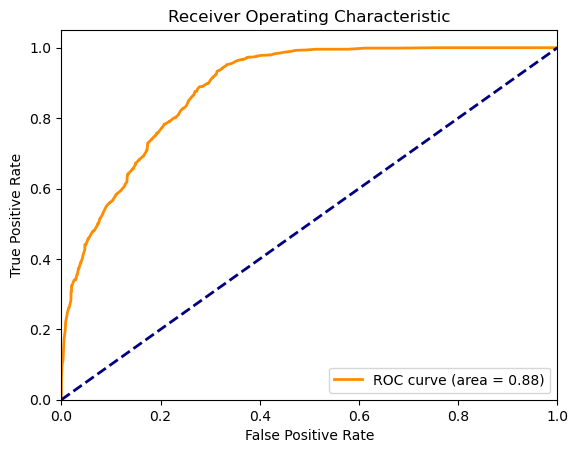

In [17]:
# Get predicted probabilities for class 1
y_prob = rf_classifier.predict_proba(X_test)[:, 1]

# custom_threshold = 0.4  # You can adjust this value
# y_pred = (y_prob >= custom_threshold).astype(int)

# Classification Report
class_report = classification_report(y_test, y_pred)
print("Classification Report:")
print(class_report)

# F1 Score
f1 = f1_score(y_test, y_pred)
print(f"F1 Score: {f1:.2f}")

# Recall
recall = recall_score(y_test, y_pred)
print(f"Recall: {recall:.2f}")

# Precision
precision = precision_score(y_test, y_pred)
print(f"Precision: {precision:.2f}")

# AUC Score
auc_score = roc_auc_score(y_test, y_prob)
print(f"AUC Score: {auc_score:.2f}")

# ROC Curve
fpr, tpr, thresholds = roc_curve(y_test, y_prob)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

## Save the model as pickle
Saving a trained Random Forest Classifier model to a file using joblib and subsequently loading it for future use.

In [18]:
import joblib

# Save the model to a file
joblib.dump(rf_classifier, 'epp_model_rf_nw.pkl')

# Load the model from the file
loaded_model = joblib.load('epp_model_rf_nw.pkl')

# Upload the model 
wslib.upload_file(file_path="epp_model_rf_nw.pkl", asset_name="epp_model_rf_nw.pkl", overwrite=True)

{'name': 'epp_model_rf_nw.pkl',
 'asset_type': 'data_asset',
 'asset_id': 'c396294b-6fd9-4850-a0c1-5d08f994c487',
 'attachment_id': '15fcfda5-4688-4f4c-a45f-ebc994ad8cf7',
 'filepath': 'epp_model_rf_nw.pkl',
 'data_size': 23388601,
 'mime': 'application/binary',
 'summary': ['created or overwritten file in storage', 'updated attachment'],
 'input_file_copied': True}